In [2]:
!nvidia-smi

Wed Feb 24 01:04:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.40.04    Driver Version: 418.40.04    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   46C    P0    62W / 250W |   2890MiB / 16130MiB |     90%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import numpy as np
import h5py
import unet_uae_filter_16_32_32_64 as vae_util
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf 
# tf.config.gpu.set_per_process_memory_fraction(0.75)
# tf.config.gpu.set_per_process_memory_growth(True)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
K.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [4]:
def load_data(data_path, array_name_list):
    hf_r = h5py.File(data_path, 'r')
    result = []
    for name in array_name_list:
        result.append(np.array(hf_r.get(name)))
    hf_r.close()
    return result

In [5]:
data_dir = './data'
# load training data
data_path = os.path.join(data_dir, '2998reals_ccs_data_xyz_20_20_5')
sat_t, logk, p_t, ground_disp_t = load_data(data_path, ['sat', 'logk', 'p', 'ground_disp'])
# sat_t = np.delete(sat_t, 1251, axis = 0) # index 1251 should be removed as an outlier
# logk = np.delete(logk, 1251, axis = 0)
# load eval data
print('sw_t shape is ', sat_t.shape)
print('logk shape is ', logk.shape)
print('p_t shape is ', p_t.shape)
print('ground_disp shape is ', ground_disp_t.shape)

sw_t shape is  (2998, 11, 12, 40, 40)
logk shape is  (2998, 12, 40, 40)
p_t shape is  (2998, 11, 12, 40, 40)
ground_disp shape is  (2998, 11, 41, 41)


In [6]:
print('p_t max is ', np.max(p_t))
print('p_t min is ', np.min(p_t))

p_t max is  21324300.0
p_t min is  13573000.0


In [7]:
depth = 10
nr = logk.shape[0]
train_nr = 2000
test_nr = 50

In [8]:
p_t_mean = np.mean(p_t[:train_nr, ...], axis = 0, keepdims = True)
p_t_std = np.std(p_t[:train_nr, ...], axis = 0, keepdims = True)
p_t = p_t - p_t_mean
print('max p is ', np.max(p_t[:train_nr, ...]), ', min p is ', np.min(p_t[:train_nr, ...]))
max_p = np.max(p_t[:train_nr, ...], axis=(0,1,2,3), keepdims = True)
min_p = np.min(p_t[:train_nr, ...], axis=(0,1,2,3), keepdims = True)

max p is  2454935.75 , min p is  -1474726.6999999993


In [9]:
# epsilon = 1e-6
# p_t = (p_t - min_p)/(max_p - min_p + 1e-6)

p_t = p_t / (p_t_std + 1)

In [10]:
print('max p is ', np.max(p_t), ', min p is ', np.min(p_t))
print('max p train is ', np.max(p_t[:train_nr, ...]), ', min p train is ', np.min(p_t[:train_nr, ...]))
print('max p validation is ', np.max(p_t[test_nr:, ...]), ', min p validation is ', np.min(p_t[test_nr:, ...]))

max p is  7.385882138910094 , min p is  -5.3237042103507966
max p train is  7.385882138910094 , min p train is  -5.3237042103507966
max p validation is  7.385882138910094 , min p validation is  -5.3237042103507966


In [11]:
#step_index = [1, 2, 3, 6, 8, 10, 12, 14, 17, 20]
step_index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_x = logk[:train_nr, ...]
train_y = p_t[:train_nr, step_index, :, :, :]

test_x = logk[nr-test_nr:, ...]
test_y = p_t[nr-test_nr:, step_index, :, :, :]

train_x = train_x[:, :, :, :, None]
train_y = train_y[:, :, :, :, :, None]
test_x = test_x[:, :, :, :, None]
test_y = test_y[:, :, :, :, :, None]
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape is ', test_x.shape)
print('test_y shape is ', test_y.shape)

train_x shape is  (2000, 12, 40, 40, 1)
train_y shape is  (2000, 10, 12, 40, 40, 1)
test_x shape is  (50, 12, 40, 40, 1)
test_y shape is  (50, 10, 12, 40, 40, 1)


<Figure size 432x288 with 0 Axes>

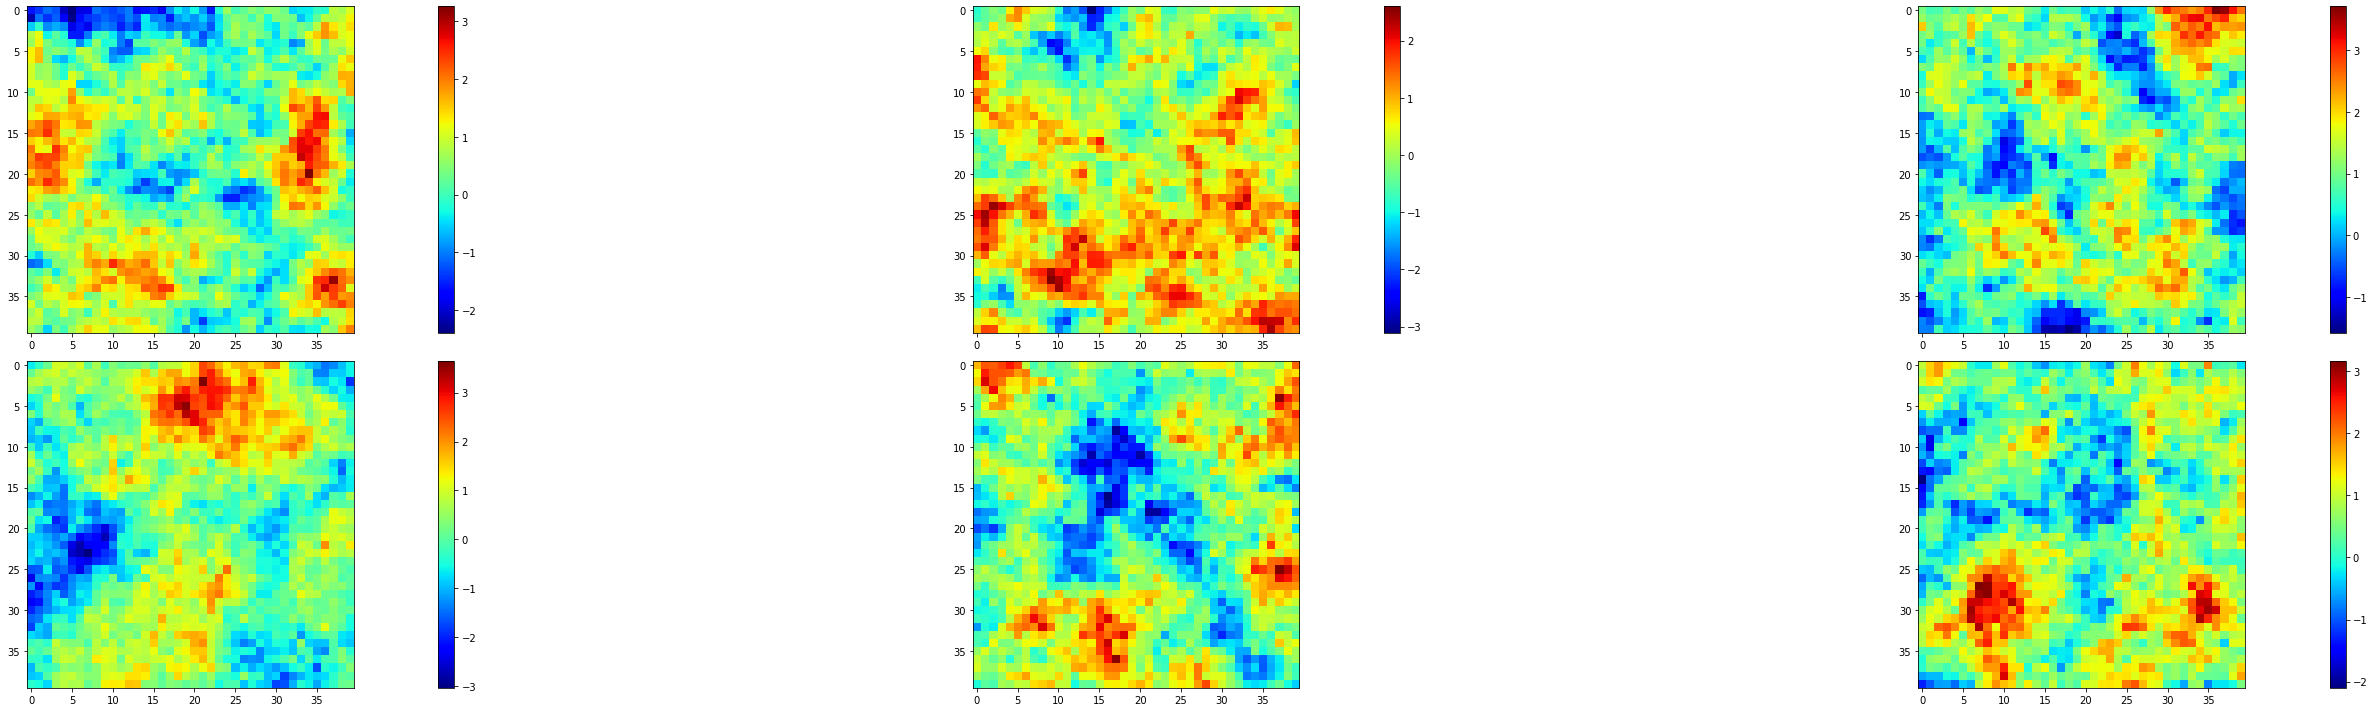

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('jet')
ind_case = [0, 10, 20, 30, 40, 50]
plt.figure(figsize=(50,10))
for i, k in enumerate(ind_case):
    plt.subplot(2, 3, i+1)
    plt.imshow(train_x[k, 0, :, :, 0])
    plt.colorbar(fraction=0.046)
    plt.tight_layout()
plt.show()

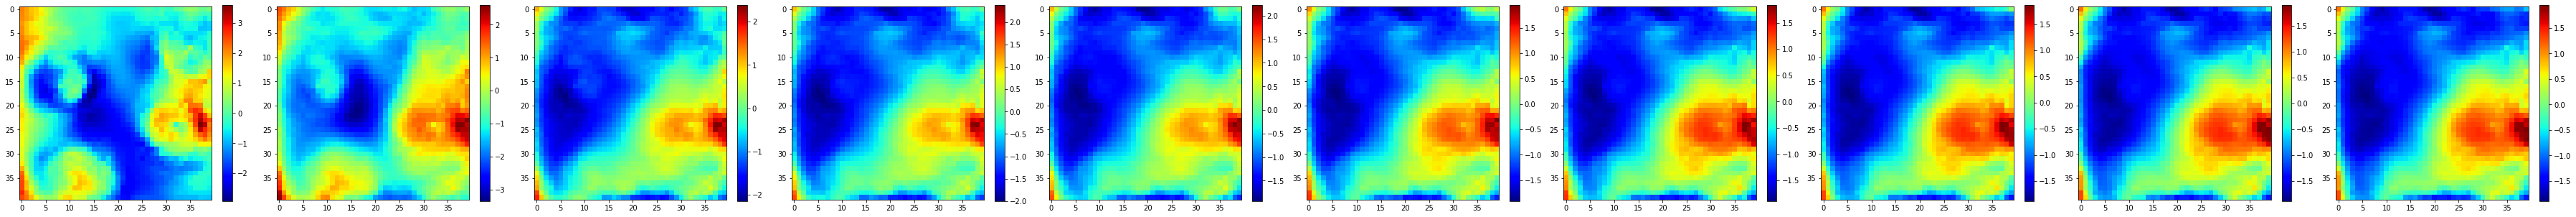

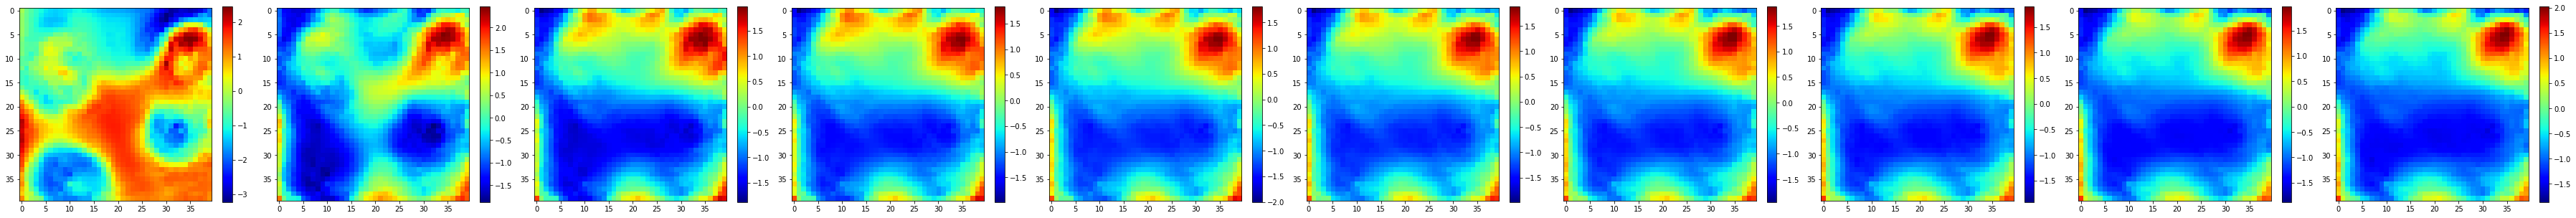

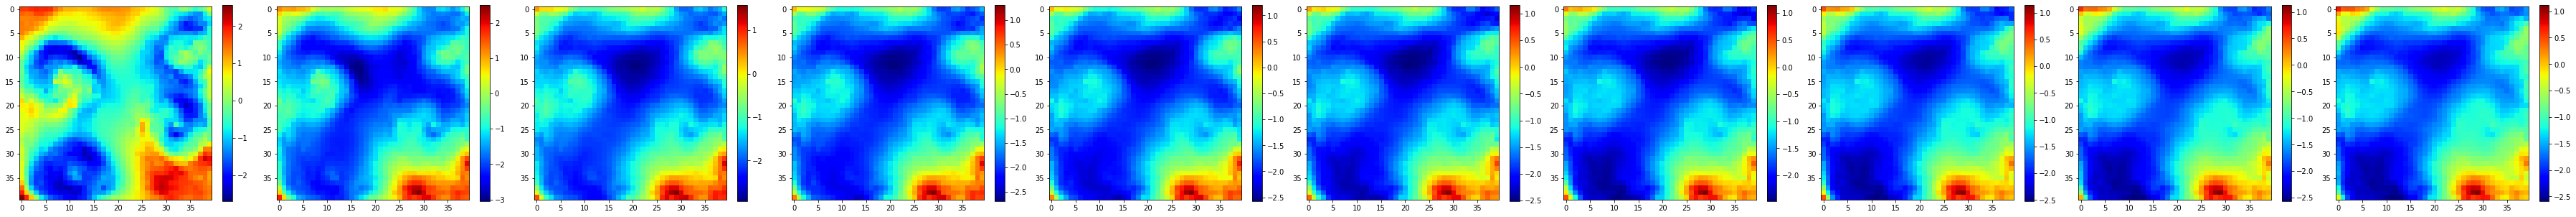

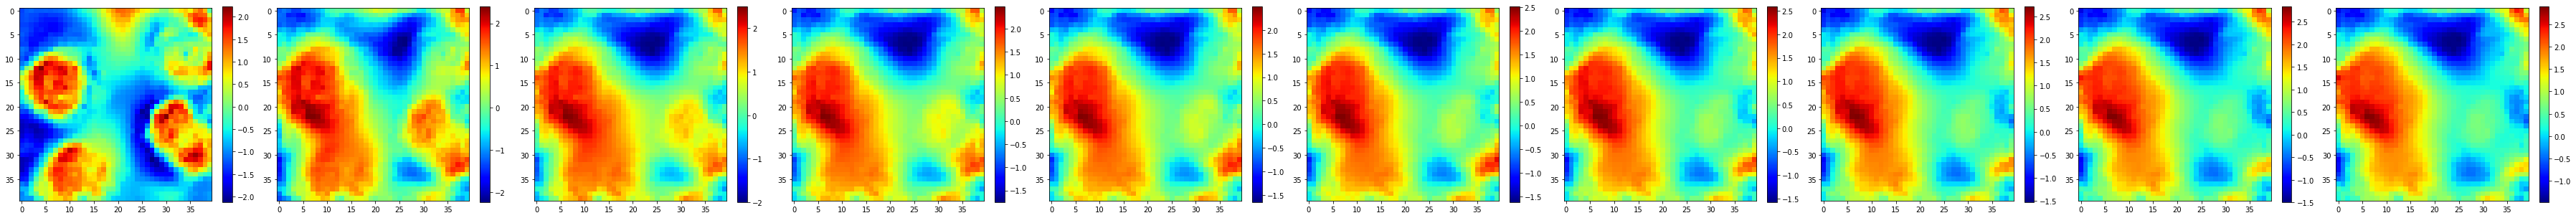

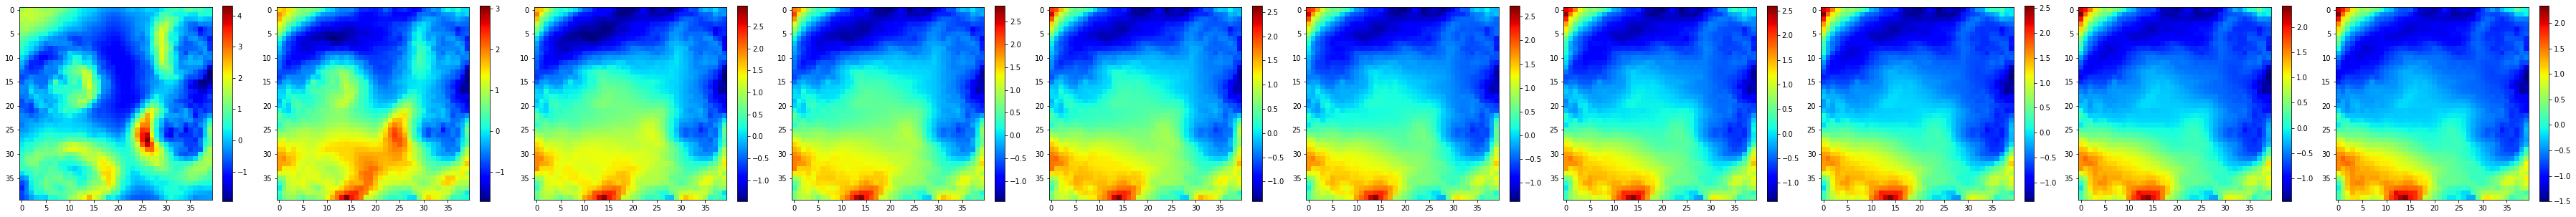

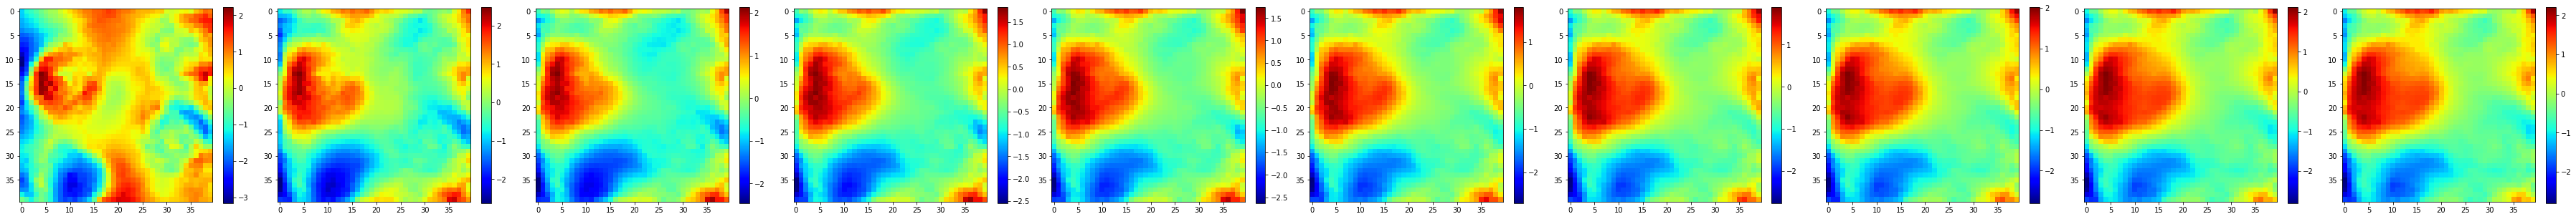

In [13]:
for i, k in enumerate(ind_case):
    plt.figure(figsize=(50,50))
    for i_tstep in range(depth):
        plt.subplot(1, depth, i_tstep+1)
        plt.imshow(train_y[k, i_tstep, 0, :, :, 0])
        plt.colorbar(fraction=0.046)
        plt.tight_layout()
plt.show()

In [14]:
input_shape=(12, 40, 40, 1)
vae_model,_ = vae_util.create_vae(input_shape, depth)
vae_model.summary(line_length=150)





______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
image (InputLayer)                               (None, 12, 40, 40, 1)            0                                                                   
______________________________________________________________________________________________________________________________________________________
conv3d_1 (Conv3D)                                (None, 6, 20, 20, 16)            448               image[0][0]                                       
______________________________________________________________________________________________________________________________________________________
batch_normalization_1 (BatchNormalization)       (None, 6, 20, 20, 16)            64      

In [15]:
output_dir = 'saved_models/'
epochs = 500
train_nr = train_x.shape[0]
test_nr = 10
batch_size = 4
num_batch = int(train_nr/batch_size) 

In [16]:
def vae_loss(x, t_decoded):
    '''Total loss for the plain UAE'''
    return K.mean(reconstruction_loss(x, t_decoded))


def reconstruction_loss(x, t_decoded):
    '''Reconstruction loss for the plain UAE'''

    return K.sum((K.batch_flatten(x) - K.batch_flatten(t_decoded)) ** 2, axis=-1)

def hard_data_loss(x, t_decoded):
    '''Compute Hard Data at Well Loc'''
    # prod 0——based [11,12],[41, 43],[10, 42],[42, 10]
    
    well_loc_x = [8, 10, 35, 32]
    well_loc_y = [15, 35, 9, 25]
    result = 0.
    for i in range(len(well_loc_x)):
        result = result + K.sum((K.batch_flatten(x[:, :, :, well_loc_y[i], well_loc_x[i], :]) - K.batch_flatten(t_decoded[:, :, :, well_loc_y[i], well_loc_x[i], :]))**2, axis = -1)
    return K.mean(result)

def joint_loss(x, t_decoded):
    return vae_loss(x, t_decoded) + 0 * hard_data_loss(x, t_decoded)

In [17]:
def relative_error(x, t_decoded):
    return K.mean(K.abs(x - t_decoded) / (K.abs(x) + K.abs(t_decoded)))

In [18]:
opt = Adam(lr=3e-4)
vae_model.compile(loss = joint_loss, optimizer = opt, metrics = [vae_loss, hard_data_loss, relative_error])

In [19]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lrScheduler = ReduceLROnPlateau(monitor = 'loss', factor = 0.5, patience = 10, cooldown = 1, verbose = 1, min_lr = 1e-7)
filePath = 'saved_models/saved-model-10steps-lr3e-4-pressure-detrend-hd-0-filter_16_32_32_64-mse-{epoch:03d}-{val_loss:.2f}.h5'
checkPoint = ModelCheckpoint(filePath, monitor = 'val_loss', verbose = 1, save_best_only = False, \
                             save_weights_only = True, mode = 'auto', period = 20)

callbacks_list = [lrScheduler, checkPoint]


In [20]:
history = vae_model.fit(train_x, train_y, batch_size = batch_size, epochs = epochs, \
                        verbose = 1, validation_data = (test_x, test_y), callbacks = callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2000 samples, validate on 50 samples
Epoch 1/500




2000/2000 [==============================] - 137s 68ms/step - loss: 107257.1794 - vae_loss: 107257.1794 - hard_data_loss: 248.7685 - relative_error: 0.5222 - val_loss: 115864.3319 - val_vae_loss: 115864.3319 - val_hard_data_loss: 277.7769 - val_relative_error: 0.4293
Epoch 2/500
2000/2000 [==============================] - 122s 61ms/step - loss: 59798.4415 - vae_loss: 59798.4414 - hard_data_loss: 146.4494 - relative_error: 0.4183 - val_loss: 42636.2300 - val_vae_loss: 42636.2298 - val_hard_data_loss: 110.9037 - val_relative_error: 0.3491
Epoch 3/500
2000/2000 [==============================] - 122s 61ms/step - loss: 48560.7841 - vae_loss: 48560.7836 - hard_data_loss: 121.3233 - relative_error: 0.3904 - val_loss: 58346.7235 - val_vae_loss: 58346.7234 - val_hard_data_loss: 114.6495 - val_relative_error: 0.3489
Epoch 4/500
2000/2000 

In [ ]:
#exit()

In [ ]:
import pickle
with open('HISTORY-pressure-mse-hd500-filter_16_32_32_64.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

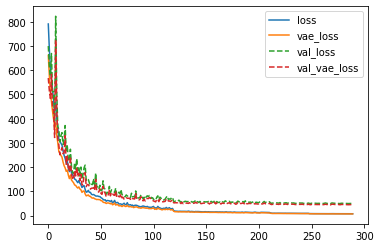

In [22]:
plt.figure()
plt.plot(history.history['loss'][10:300], label = 'loss')
plt.plot(history.history['vae_loss'][10:300], label = 'vae_loss')
plt.plot(history.history['val_loss'][10:300], '--', label = 'val_loss')
plt.plot(history.history['val_vae_loss'][10:300], '--', label = 'val_vae_loss')
plt.legend()
plt.show()